# non-parametric cerebellumm volumetry analysis
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32), PPMI/ADNI NC (116/308) QC to be applied.

## Tasks: permutation tests for 
- Comparing left/right cerebellar gray/white matter volumes (left and right)
- Comparing lobular volumes (9 for SUIT atlas, 4 for MDTB atlas)

## Covariates
- Age, Sex, intracranial volume (eTIV, infratentorium, cerebellar volume), site.

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
data_all_file  = data_dir/'all_Des-cere_preped_qcInfo.csv'
matched_data_file = data_dir/'matched_Des-cere_qced.csv'
data_df    = pd.read_csv(data_all_file , sep=',', header=0, index_col=0);
matched_df = pd.read_csv(matched_data_file , sep=',', header=0, index_col=0);

# Apply QC to the data_df
qc_th=2
data_qc_df=data_df[(data_df['freesurfer_score']>=qc_th)&(data_df['suit_score']>=qc_th)&(data_df['maget_score']>=qc_th)];
print("Data before QC: ", data_df.shape)
print("Data after QC: ", data_qc_df.shape)
print("Data after match: ", matched_df.shape)

Data before QC:  (495, 799)
Data after QC:  (364, 799)
Data after match:  (211, 799)


In [2]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
analysis_list = ['age', 'sex', 'male', 'group', 'cohort','site','eTIV', 'is_mni', 'is_ppmi', 'is_adni', 
                 'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol', 'Cerebellum_White_Matter', 'Cerebellum_Cortex', 
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels;
# pick ROIs
data_df = data_df.loc[:, analysis_list].copy()
data_qc_df = data_qc_df.loc[:, analysis_list].copy()
matched_df = matched_df.loc[:, analysis_list].copy()

In [3]:
# Preparing data
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df

# get indicator variable
alpha_=5; n_permu_=5000;

## covariates and target labels
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];
tar_list = cerebellum_list+lobular_list;
df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])
sts_tests_list = ['Cohen_d', 'rank_sum']; 
group_mni_list = ['ET','NC'];

In [19]:
data_qc_df.columns

Index(['age', 'sex', 'male', 'group', 'cohort', 'site', 'eTIV',
       'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol',
       'Cerebellum_White_Matter', 'Cerebellum_Cortex',
       'Left_Cerebellum_White_Matter', 'Left_Cerebellum_Cortex',
       'Right_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Left_I_IV',
       'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb',
       'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate',
       'Left_Interposed', 'Left_Fastigial', 'Right_I_IV', 'Right_V',
       'Right_VI', 'Right_CrusI', 'Right_CrusII', 'Right_VIIb', 'Right_VIIIa',
       'Right_VIIIb', 'Right_IX', 'Right_X', 'Right_Dentate',
       'Right_Interposed', 'Right_Fastigial', 'Vermis_VI', 'Vermis_CrusI',
       'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa', 'Vermis_VIIIb',
       'Vermis_IX', 'Vermis_X', 'MDTB_1', 'MDTB_2', 'MDTB_3', 'MDTB_4',
       'MDTB_5', 'MDTB_6', 'MDTB_7', 'MDTB_8', 'MDTB_9', 'MDTB_10'],
      dtype='object')

## Cerebellar volumentry for MNI ET/NC (38/32) dataset
    1. Experiment 1: without controling for any covariates;
    2. Experiment 2: control age/sex/eTIV with rm control group method;
    3. Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    4. Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    5. Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    6. Experiment 6: control age/sex/cerebellumVol with rm control group method;
    7. Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;

In [20]:
def mni_vol_stats(df, tar_list, alpha_, n_permu_, sts_tests_list):
    # Experiment 1: without controling for any covariates;
    res_cere_gw = cal_es(df, tar_list, alpha_, n_permu_, sts_tests_list, group_mni_list, "");
    # Experiment 2: control age/sex/eTIV with rm control group method;
    dat_cere_gw_1, cere_gw_col_1 = ctr_tiv(df, tar_list, 'eTIV', ['age','male'], 'rm_norm')
    res_cere_gw_1 = cal_es(dat_cere_gw_1, cere_gw_col_1, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,TIV");
    res_cere_gw_1['ROI']=res_cere_gw_1['ROI'].map(lambda x: x[0:-14]);
    # Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    dat_cere_gw_2, cere_gw_col_2 = ctr_tiv(df, tar_list, 'InfraTentorialVol', ['age','male'], 'rm_norm')
    res_cere_gw_2 = cal_es(dat_cere_gw_2, cere_gw_col_2, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,infTV");
    res_cere_gw_2['ROI']=res_cere_gw_2['ROI'].map(lambda x: x[0:-27]);
    #Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    dat_cere_gw_3, cere_gw_col_3 = ctr_tiv(df, tar_list, 'eTIV', ['age','male'], 'dpa')
    res_cere_gw_3 = cal_es(dat_cere_gw_3, cere_gw_col_3, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,TIV");
    res_cere_gw_3['ROI']=res_cere_gw_3['ROI'].map(lambda x: x[0:-13])
    #Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    dat_cere_gw_4, cere_gw_col_4 = ctr_tiv(df, tar_list, 'InfraTentorialVol', ['age','male'], 'dpa')
    res_cere_gw_4 = cal_es(dat_cere_gw_4, cere_gw_col_4, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,infTV");
    res_cere_gw_4['ROI']=res_cere_gw_4['ROI'].map(lambda x: x[0:-13]);
    #Experiment 6: control age/sex/cerebellumVol with rm control group method;
    dat_cere_gw_5, cere_gw_col_5 = ctr_tiv(df, tar_list, 'cerebellumVol', ['age','male'], 'rm_norm')
    res_cere_gw_5 = cal_es(dat_cere_gw_5, cere_gw_col_5, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,Cere");
    res_cere_gw_5['ROI']=res_cere_gw_5['ROI'].map(lambda x: x[0:-23]);
    #Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;
    dat_cere_gw_6, cere_gw_col_6 = ctr_tiv(df, tar_list, 'cerebellumVol', ['age','male'], 'dpa')
    res_cere_gw_6 = cal_es(dat_cere_gw_6, cere_gw_col_6, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,Cere");
    res_cere_gw_6['ROI']=res_cere_gw_6['ROI'].map(lambda x: x[0:-13]);
    res_method_df=pd.concat([res_cere_gw, res_cere_gw_1, res_cere_gw_2, res_cere_gw_5, res_cere_gw_3, res_cere_gw_4, res_cere_gw_6])
    return res_method_df
# MNI cohort after QC
mni_df = data_qc_df[data_qc_df['cohort']=='MNI'].copy();
mni_method_df = mni_vol_stats(mni_df, tar_list, alpha_, n_permu_, sts_tests_list);

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_eTIV_age_male', 'Left_Cerebellum_White_Matter_eTIV_age_male', 'Right_Cerebellum_Cortex_eTIV_age_male', 'Right_Cerebellum_White_Matter_eTIV_age_male', 'Cerebellum_Cortex_eTIV_age_male', 'Cerebellum_White_Matter_eTIV_age_male', 'Vermis_VI_eTIV_age_male', 'Vermis_CrusI_eTIV_age_male', 'Vermis_CrusII_eTIV_age_male', 'Left_CrusI_eTIV_age_male', 'Right_CrusI_eTIV_age_male', 'Left_CrusII_eTIV_age_male', 'Right_CrusII_eTIV_age_male', 'Left_Dentate_eTIV_age_male', 'Right_Dentate_eTIV_age_male', 'MDTB_1_eTIV_age_male', 'MDTB_2_eTIV_age_male', 'MDTB_4_eTIV_age_male', 'MDTB_5_eTIV_age_male']
Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_InfraTentorialVol_age_male', 'Left_Cerebellum_White_Matter_InfraTentorialVol_age_male', 'Right_Cerebellum_Cortex_InfraTentorialVol_age_male', 'Right_Cerebellum_White_Matter_InfraTentorialVol_age_male', 'Cerebellum_Cortex_InfraTentorialVol_age_male', 'Cerebellum_White_Matter_InfraTentorialVol_age_

Text(0.5, 1.0, 'Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol')

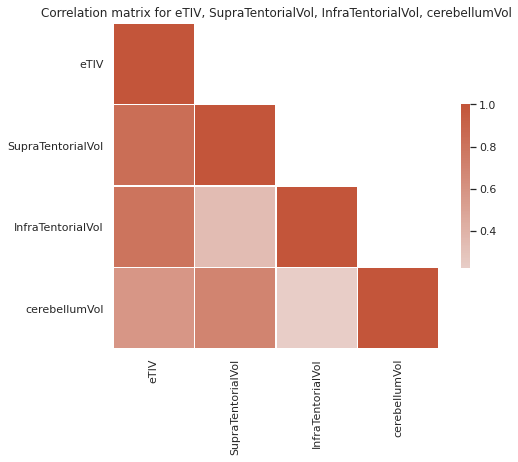

In [21]:
# report correlation between the intracranial volumes for controling
import matplotlib.pyplot as plt
vol_list = ['eTIV', 'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol'];
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_df=data_qc_df[vol_list].copy()
corr_=corr_df.corr()
mask = np.triu(np.ones_like(corr_, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.heatmap(corr_, mask=mask, cmap=cmap, vmax=1, center=0, xticklabels=vol_list, yticklabels=vol_list,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol')

In [28]:
# Control for general vis
from matplotlib.patches import Rectangle
figure_size=(22, 32);
legend_text_pos=[0.5, 0.5];
legend_font_size=26
## MNI cohort: mni_method_df 
## ALL cohort: all_method_df
## Matched cohort: matched_method_df 

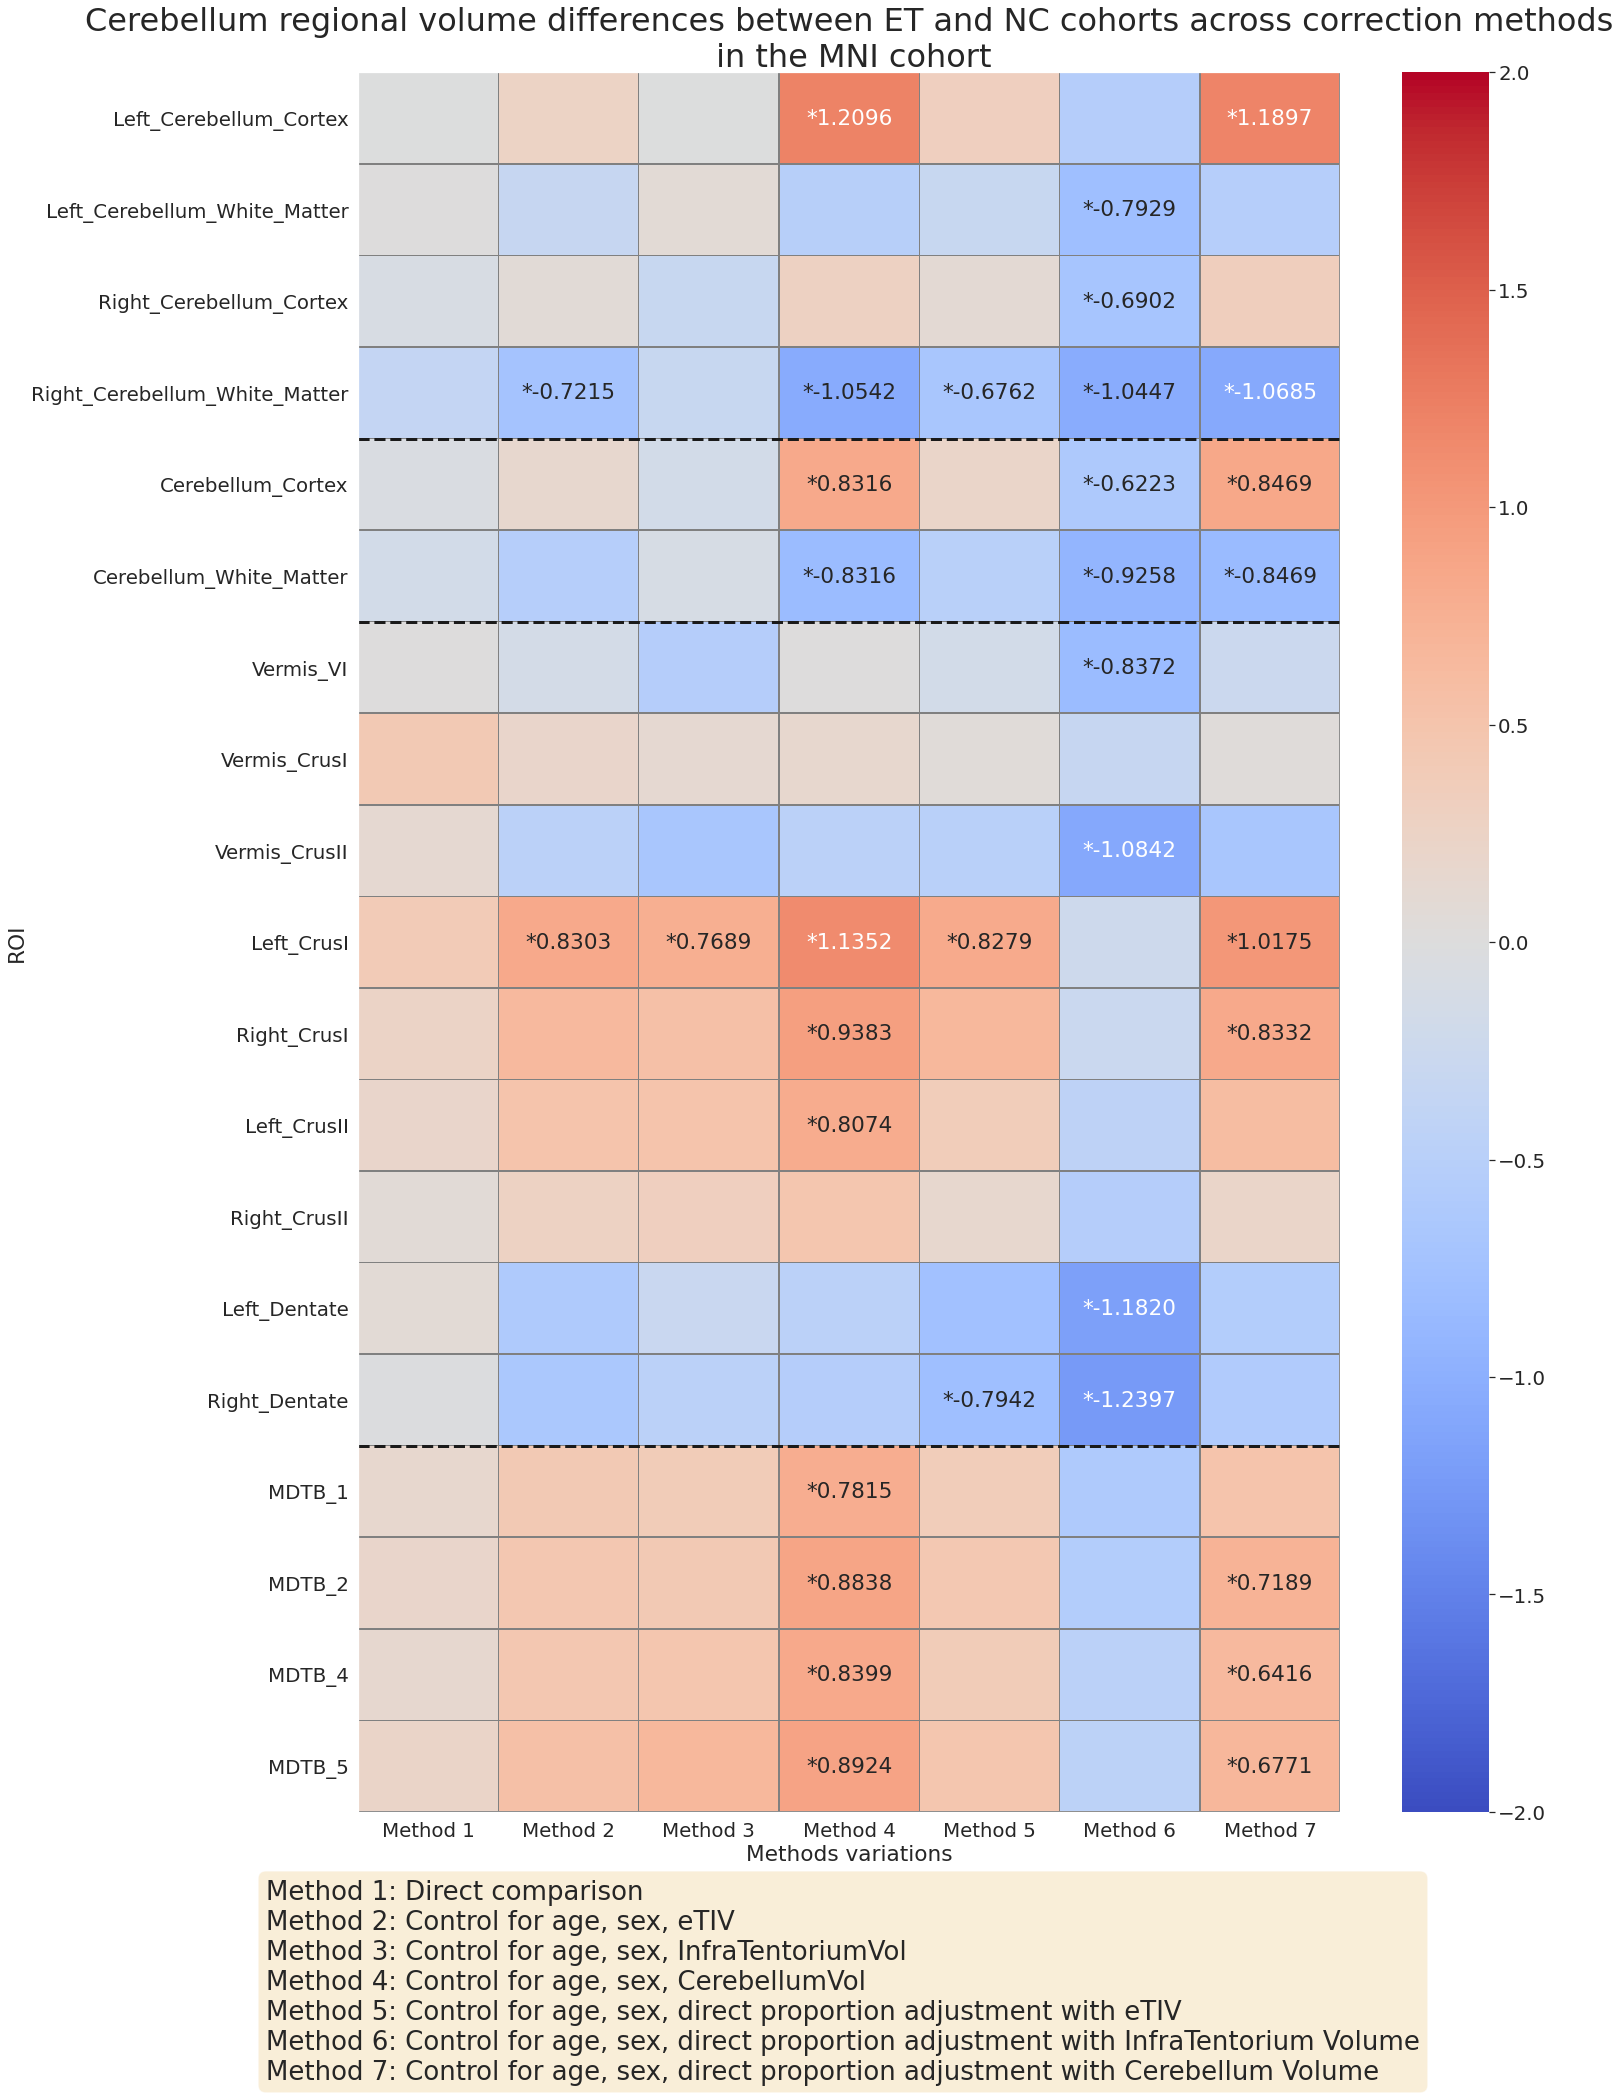

In [23]:
# Vis for methods sensitivity analysis.
# !!!! remove the blue boxes for red cells
# methods in legends
C_MAP='coolwarm'; VMIN=-2; VMAX=2;
sns.set(font_scale=1.8)
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_DPA with A,S,Cere']
# mni_method_df, mni_qc_method_df 

vis_df = mni_method_df.copy()
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]
# reorder rows
es_df_=es_df_.reindex(tar_list)
p_df_=p_df_.reindex(tar_list)
# create multiple comparison mask
def f(x):
    if float(x)==0:
        return ""
    else:
        return "*{:.4f}".format(x)
# Create 
pass_df, mask_df=creat_Bonf_df(p_df_, 0.05, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)
xticklabels_str = [ 'Method '+str(x+1) for x in range(es_df_.shape[1])] 
# Draw a heatmap with the numeric values in each cell
f1, ax1 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray')
ax1=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str,
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax1)
ax1.set_xlabel("Methods variations")
ax1.set_title('Cerebellum regional volume differences between ET and NC cohorts across correction methods\n in the MNI cohort', fontsize=32)
for _, spine in ax1.spines.items(): spine.set_visible(True)

# adding more repliccability information
from matplotlib.patches import Rectangle
lit_roi=[(3,5), (5,4), (5,5), (6,5), (5,6), (5,8)]
#for x_ in lit_roi:
#    ax1.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='blue', lw=3))
line_pos=[4,6,15]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3)
## adding text boxes
textstr = '\n'.join([
    r'Method 1: Direct comparison',
    r'Method 2: Control for age, sex, eTIV',
    r'Method 3: Control for age, sex, InfraTentoriumVol',
    r'Method 4: Control for age, sex, CerebellumVol',
    r'Method 5: Control for age, sex, direct proportion adjustment with eTIV',
    r'Method 6: Control for age, sex, direct proportion adjustment with InfraTentorium Volume',
    r'Method 7: Control for age, sex, direct proportion adjustment with Cerebellum Volume'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(legend_text_pos[0], legend_text_pos[1], textstr, transform=ax.transAxes, fontsize=legend_font_size,
        verticalalignment='top', bbox=props)
plt.show()
#f1.savefig("MNI_methods-Sensitivity_qc_non-parametric.jpg")

## Cerebellar volumentry for all 3 datasets ET/NC(38/32+116+308)
    1. Experiment 1: without controling for any covariates;
    2. Experiment 2: control age/sex/eTIV with rm control group method;
    3. Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    4. Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    5. Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    6. Experiment 6: control age/sex/cerebellumVol with rm control group method;
    7. Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;

In [5]:
# for augmented dataset
def all_vol_stats(df_all, tar_list, alpha_, n_permu_, sts_tests_list):
    # Experiment 1: without controling for any covariates;
    res_cere_gw_all = cal_es(df_all, tar_list, alpha_, n_permu_, sts_tests_list, group_mni_list, "");
    # Experiment 2: control age/sex/eTIV with rm control group method;
    dat_cere_gw_all_1, cere_gw_all_col_1 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_1 = cal_es(dat_cere_gw_all_1, cere_gw_all_col_1, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,TIV");
    res_cere_gw_all_1['ROI']=res_cere_gw_all_1['ROI'].map(lambda x: x[0:-37]);
    # Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    dat_cere_gw_all_2, cere_gw_col_all_2 = ctr_tiv(df_all, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_2 = cal_es(dat_cere_gw_all_2, cere_gw_col_all_2, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,infTV");
    res_cere_gw_all_2['ROI']=res_cere_gw_all_2['ROI'].map(lambda x: x[0:-50]);
    #Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    dat_cere_gw_all_3, cere_gw_all_col_3 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_3 = cal_es(dat_cere_gw_all_3, cere_gw_all_col_3, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,TIV");
    res_cere_gw_all_3['ROI']=res_cere_gw_all_3['ROI'].map(lambda x: x[0:-36])
    #Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    dat_cere_gw_all_4, cere_gw_col_all_4 = ctr_tiv(df_all, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_4 = cal_es(dat_cere_gw_all_4, cere_gw_col_all_4, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,infTV");
    res_cere_gw_all_4['ROI']=res_cere_gw_all_4['ROI'].map(lambda x: x[0:-36]);
    #Experiment 6: control age/sex/cerebellumVol with rm control group method;
    dat_cere_gw_all_5, cere_gw_col_all_5 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_5 = cal_es(dat_cere_gw_all_5, cere_gw_col_all_5, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,Cere");
    res_cere_gw_all_5['ROI']=res_cere_gw_all_5['ROI'].map(lambda x: x[0:-46]);
    #Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;
    dat_cere_gw_all_6, cere_gw_all_col_6 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_6 = cal_es(dat_cere_gw_all_6, cere_gw_all_col_6, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,Cere");
    res_cere_gw_all_6['ROI']=res_cere_gw_all_6['ROI'].map(lambda x: x[0:-36]);
    res_method_all_df=pd.concat([res_cere_gw_all, res_cere_gw_all_1, res_cere_gw_all_2, res_cere_gw_all_5, res_cere_gw_all_3, res_cere_gw_all_4, res_cere_gw_all_6])
    return res_method_all_df

# All cohort after QC
all_method_df = all_vol_stats(data_qc_df, tar_list, alpha_, n_permu_, sts_tests_list);
# Matched cohort after QC
matched_method_df = all_vol_stats(matched_df, tar_list, alpha_, n_permu_, sts_tests_list);

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_1_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_2_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_4_eTIV

NameError: name 'Rectangle' is not defined

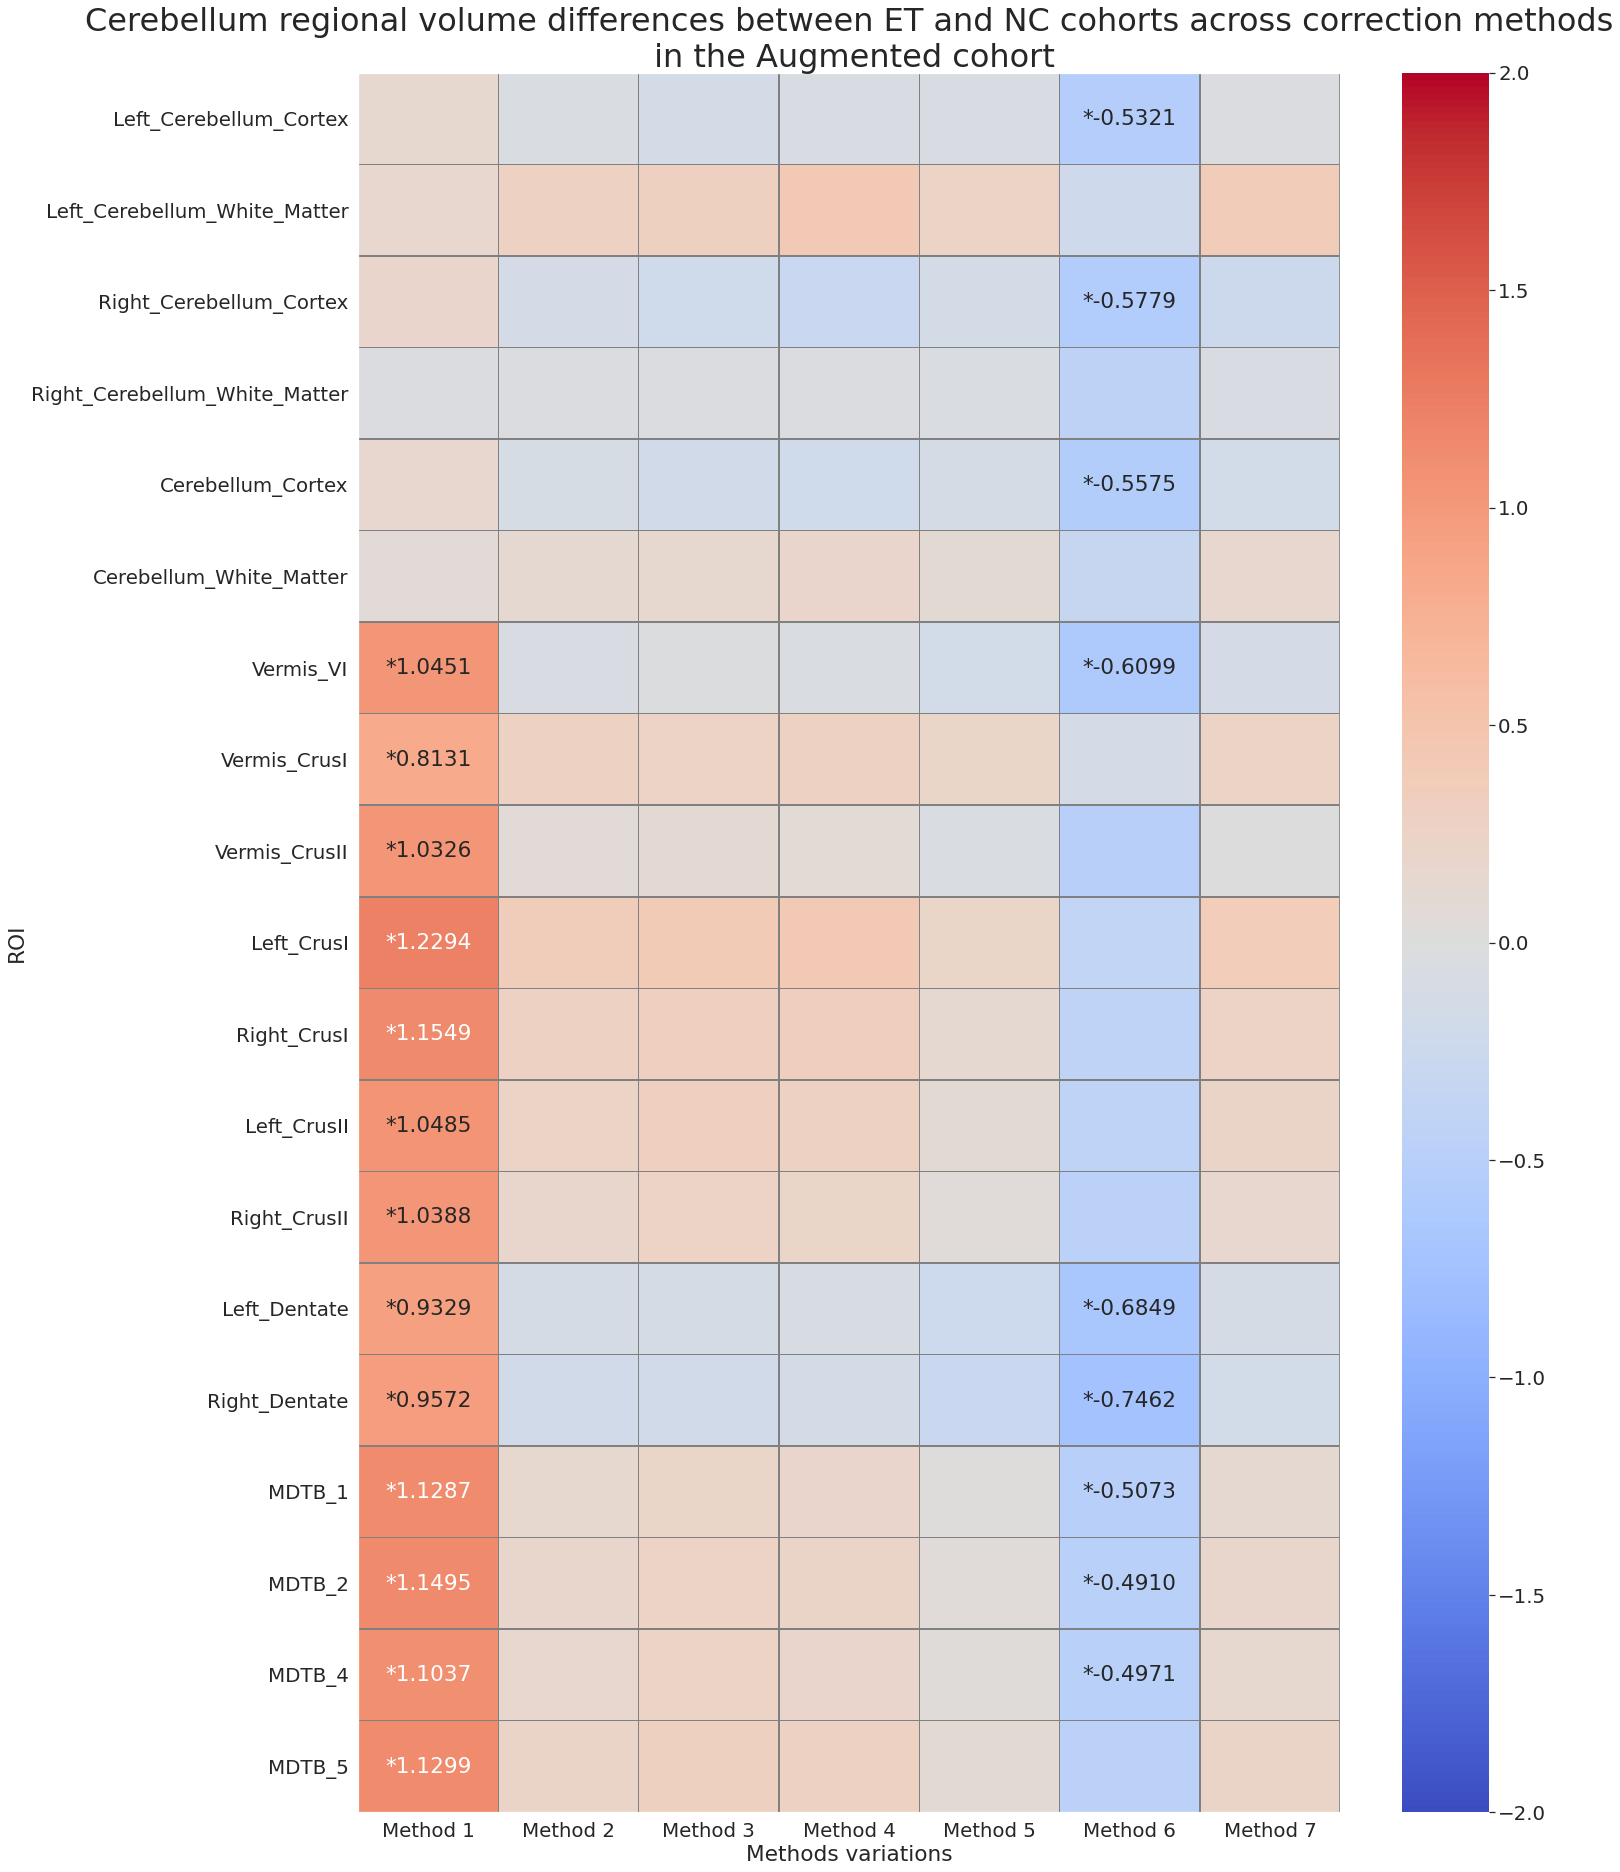

In [7]:
# Vis for methods sensitivity analysis.
C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.8)
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_DPA with A,S,Cere']

vis_df = all_method_df.copy()
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]
# reorder rows
es_df_=es_df_.reindex(tar_list)
p_df_=p_df_.reindex(tar_list)
# create multiple comparison mask
def f(x):
    if float(x)==0:
        return ""
    else:
        return "*{:.4f}".format(x)
# Create 
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)
xticklabels_str = [ 'Method '+str(x+1) for x in range(es_df_.shape[1])] 

# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray')
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str,
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2)
ax2.set_xlabel("Methods variations")
ax2.set_title('Cerebellum regional volume differences between ET and NC cohorts across correction methods\n in the Augmented cohort', fontsize=32)
for _, spine in ax2.spines.items(): spine.set_visible(True)

# adding more repliccability information (need QC done)
lit_roi_all=[(5,4), (5,6) ]
for x_ in lit_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='blue', lw=3))
line_pos=[4,6,15]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3)
## adding text boxes
textstr = '\n'.join([
    r'Method 1: Direct comparison',
    r'Method 2: Control for age, sex, cohort, eTIV',
    r'Method 3: Control for age, sex, cohort, InfraTentoriumVol',
    r'Method 4: Control for age, sex, cohort, CerebellumVol',
    r'Method 5: Control for age, sex, cohort, direct proportion adjustment with eTIV',
    r'Method 6: Control for age, sex, cohort, direct proportion adjustment with InfraTentorium Volume',
    r'Method 7: Control for age, sex, cohort, direct proportion adjustment with Cerebellum Volume'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos[0], legend_text_pos[1], textstr, transform=ax.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props)
plt.show()
f2.savefig("aug-corhorts_qc_methods-Sensitivity_non-parametric.jpg")

NameError: name 'Rectangle' is not defined

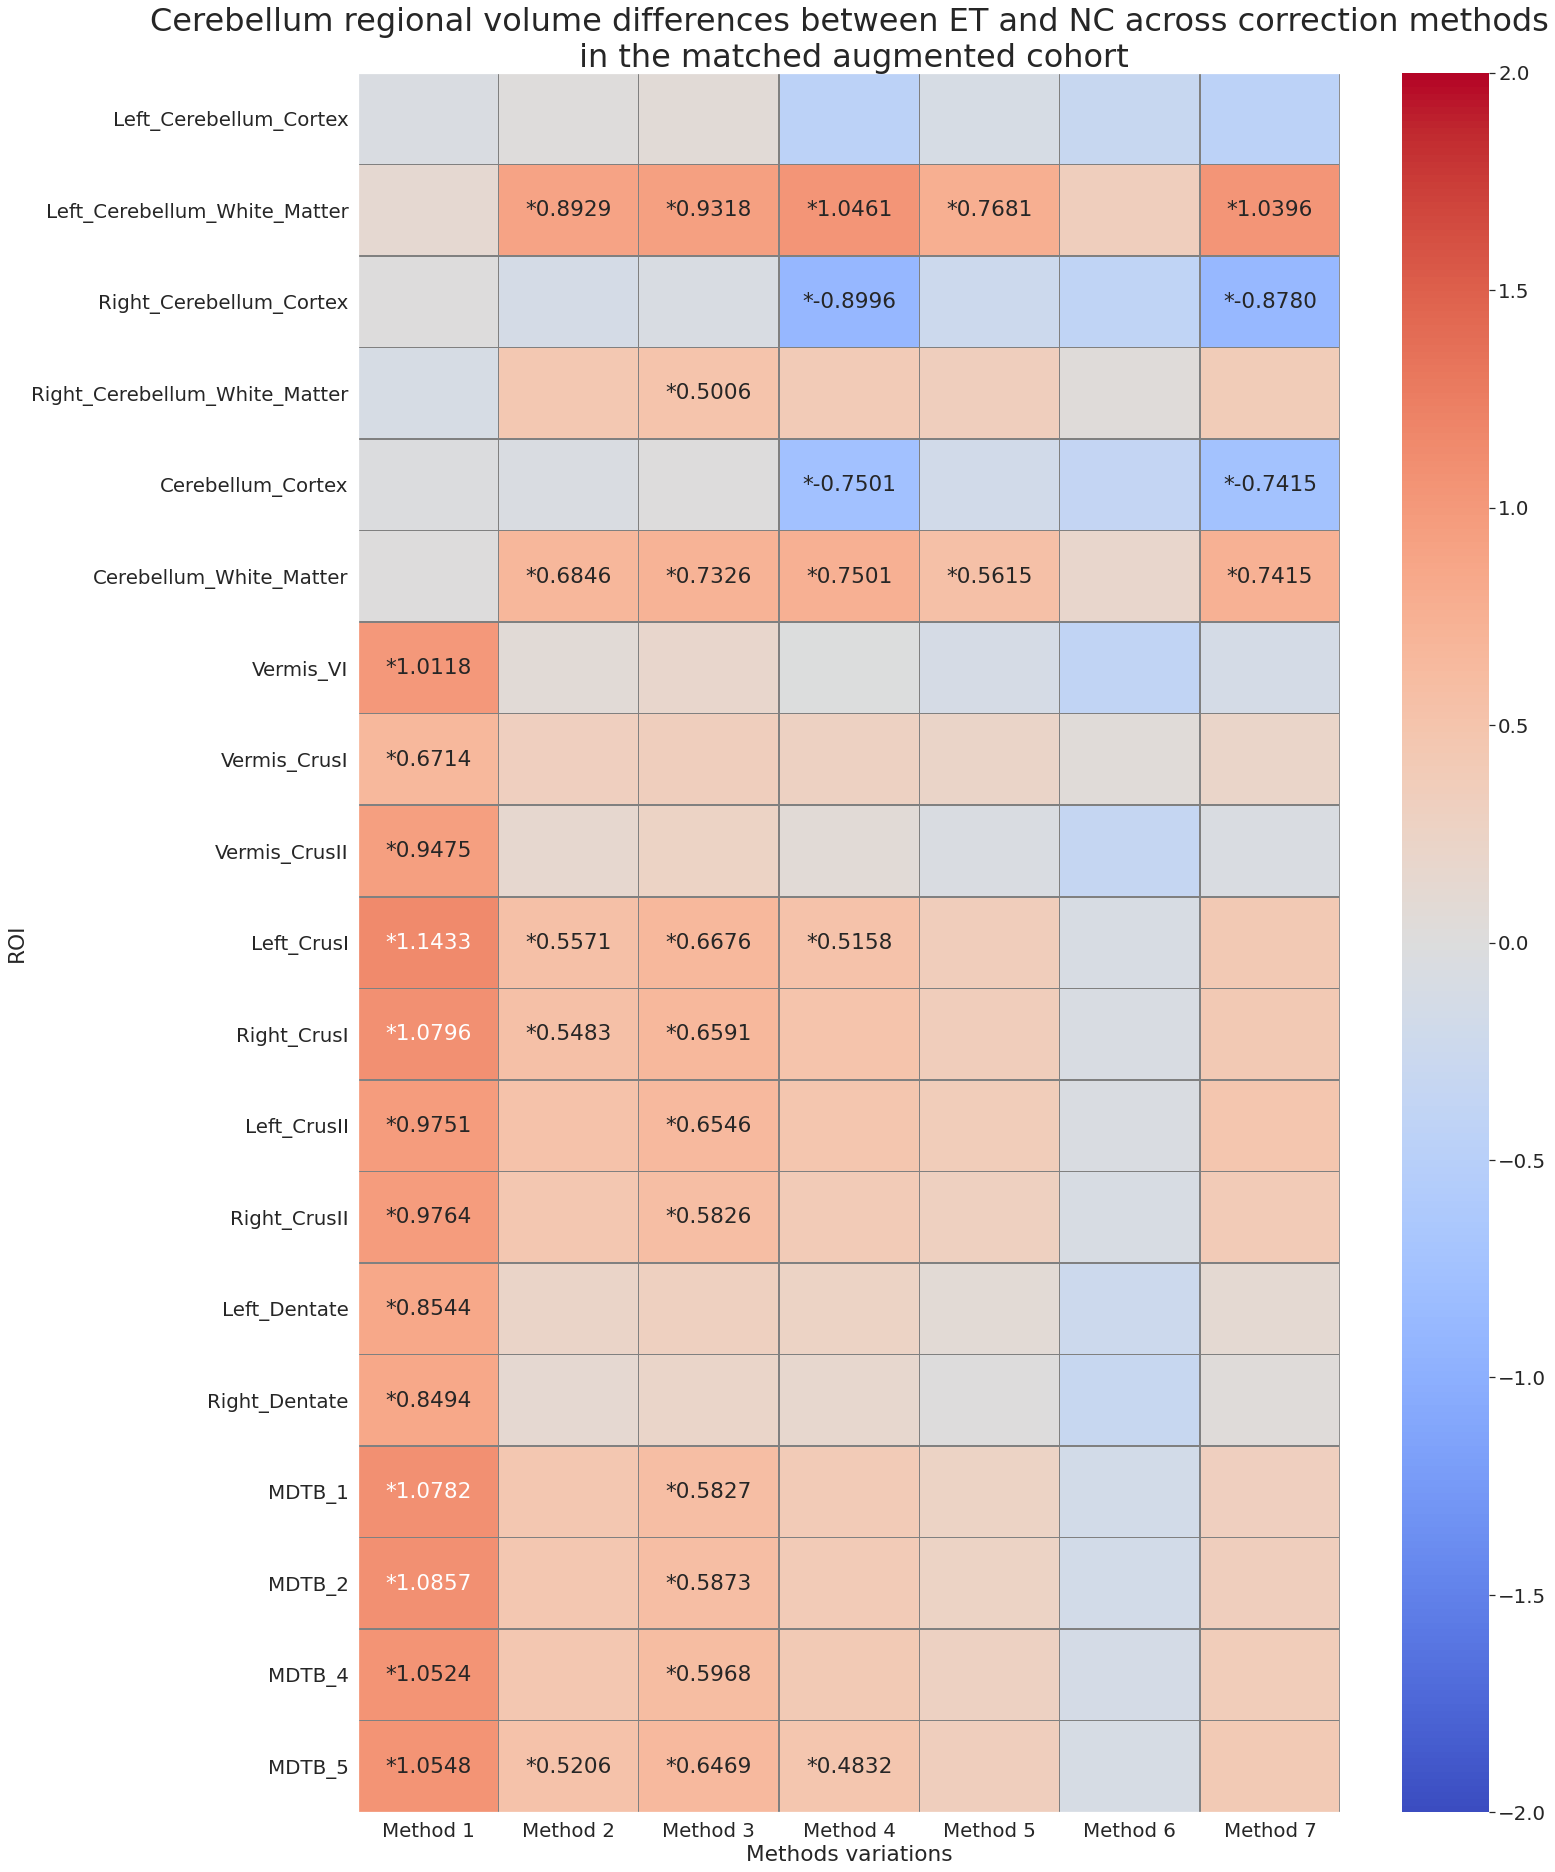

In [8]:
# Visualization of results in the matched cohort in accordance withe previous analysis.
#
C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.8)
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_DPA with A,S,Cere']

vis_df = matched_method_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]

# reorder rows
es_df_=es_df_.reindex(tar_list)
p_df_=p_df_.reindex(tar_list)
# create multiple comparison mask
def f(x):
    if float(x)==0:
        return ""
    else:
        return "*{:.4f}".format(x)
# Create 
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)

xticklabels_str = [ 'Method '+str(x+1) for x in range(es_df_.shape[1])]

# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray')
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str,
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2)
ax2.set_xlabel("Methods variations")
ax2.set_title('Cerebellum regional volume differences between ET and NC across correction methods\n in the matched augmented cohort', fontsize=32)
for _, spine in ax2.spines.items(): spine.set_visible(True)

# adding more repliccability information (need QC done)
lit_roi_all=[(3,2), (6,2) ]
for x_ in lit_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))

line_pos=[4,6,15]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3)
plt.axvline(5, ls='--',c='k', lw=3)

## adding text boxes
textstr = '\n'.join([
    r'Method 1: Direct comparison',
    r'Method 2: Control for age, sex, cohort, eTIV',
    r'Method 3: Control for age, sex, cohort, InfraTentoriumVol',
    r'Method 4: Control for age, sex, cohort, Cerebellum Volume',
    r'Method 5: Control for age, sex, cohort, direct proportion adjustment with eTIV',
    r'Method 6: Control for age, sex, cohort, direct proportion adjustment with InfraTentorium Volume',
    r'Method 7: Control for age, sex, cohort, direct proportion adjustment with Cerebellum Volume'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos[0], legend_text_pos[1], textstr, transform=ax.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props)
plt.show()
f2.savefig("matched-corhorts_qc_methods-Sensitivity_non-parametric.jpg")

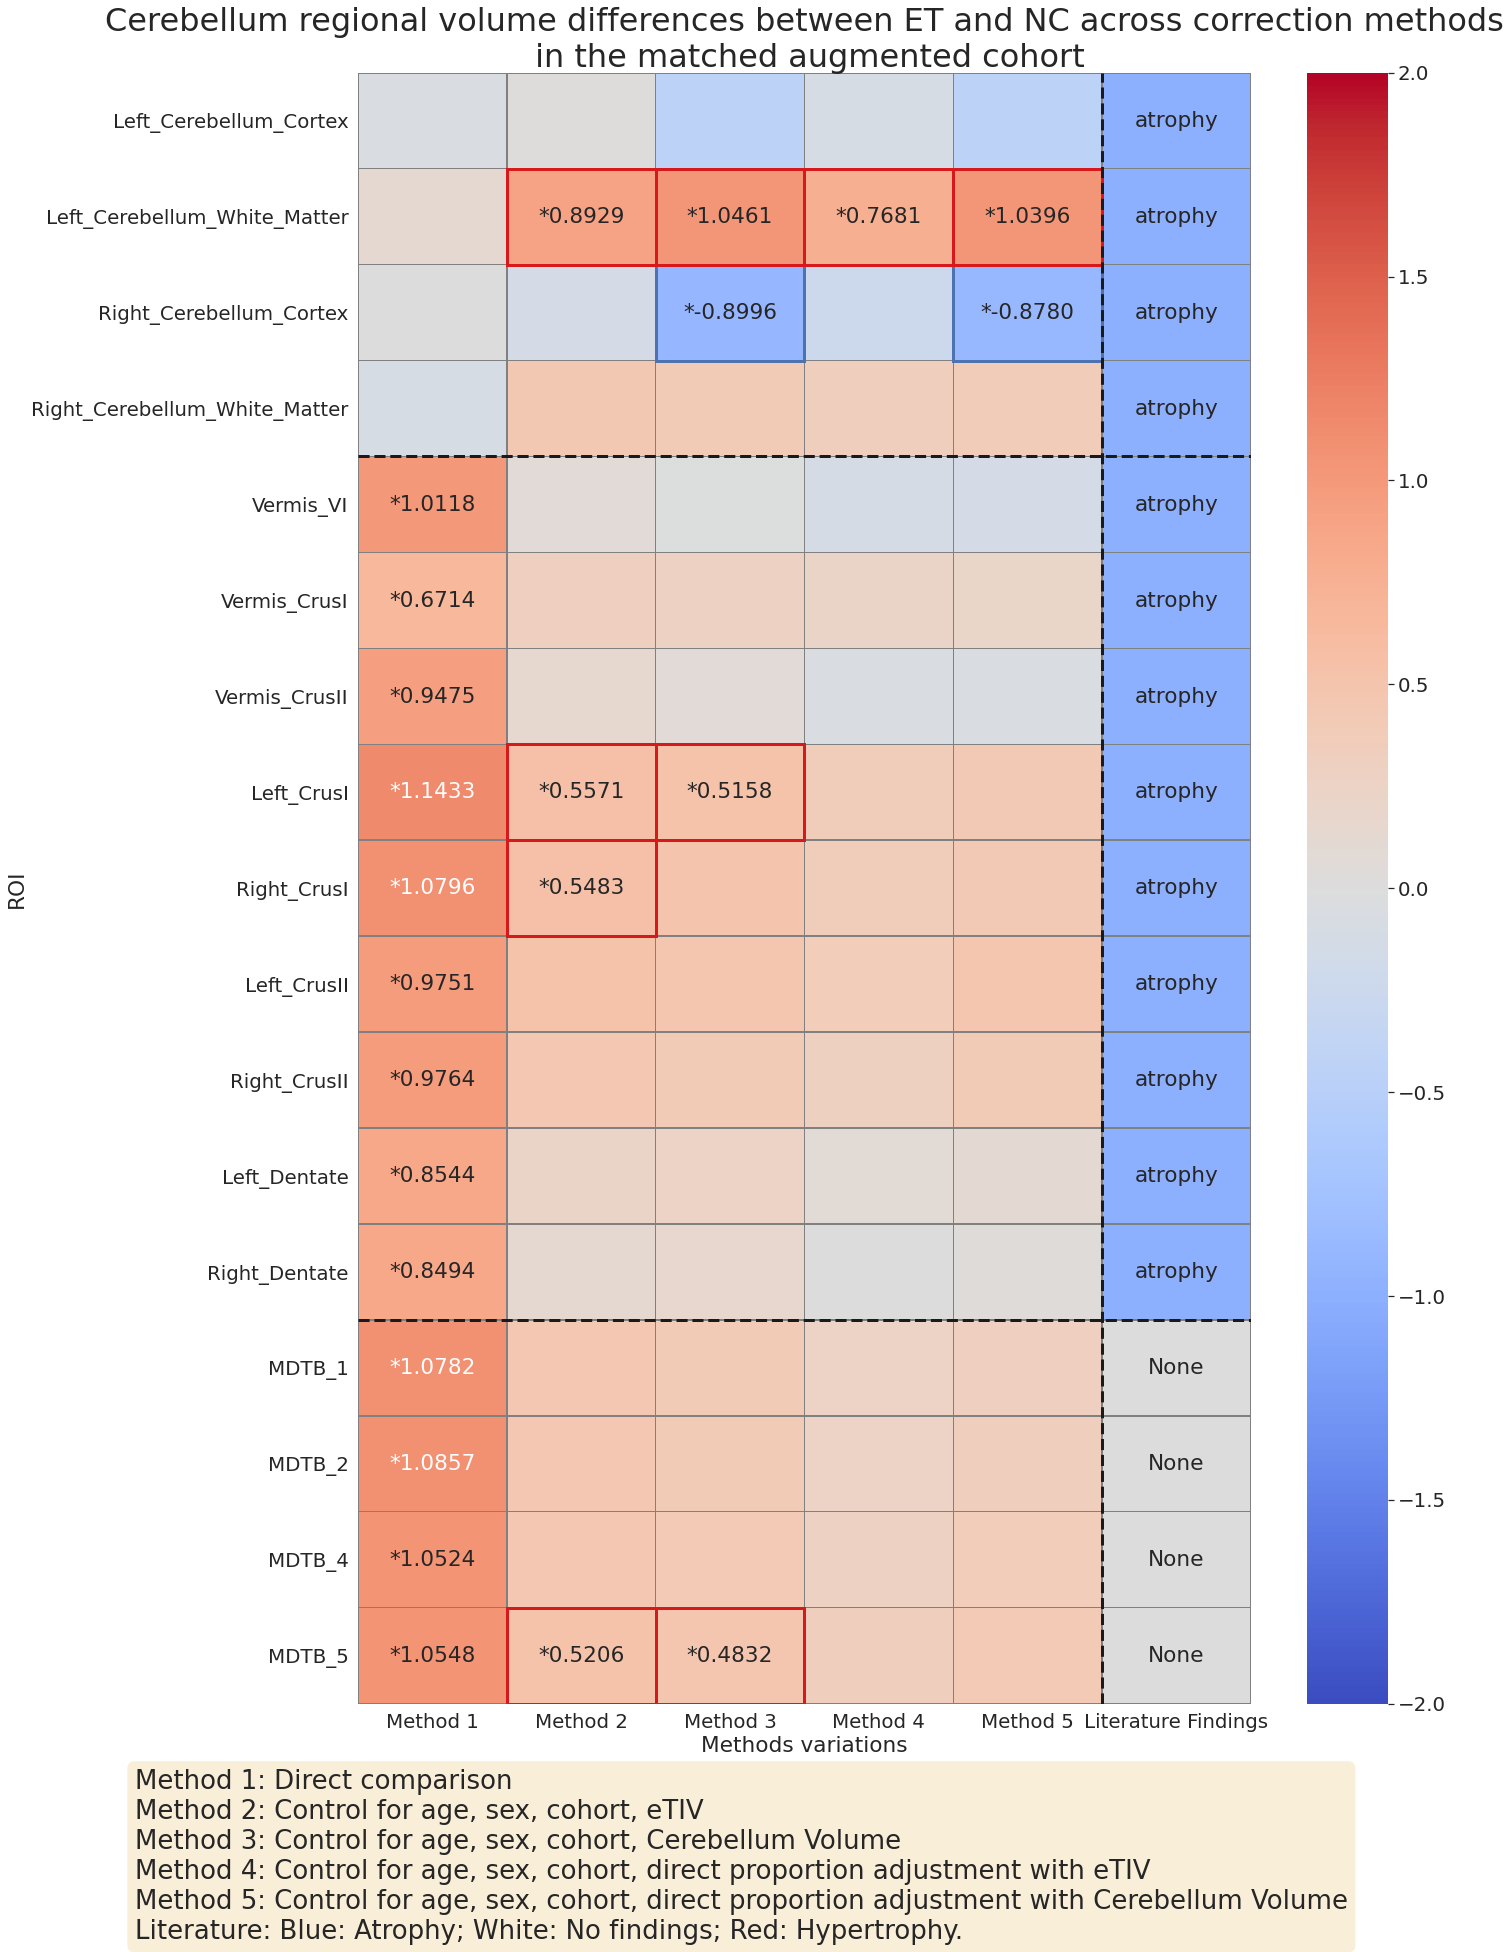

In [31]:
# This is the figure created for 2022 OHBM abstract about our priliminary results.
#
figure_size=(20, 30);
legend_text_pos=[-0.25, -0.04];
legend_font_size=26

C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.8)
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_DPA with A,S,Cere']

vis_df = matched_method_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]

# reorder rows
es_df_=es_df_.reindex(tar_list)
p_df_=p_df_.reindex(tar_list)
# create multiple comparison mask
def f(x):
    if float(x)==0:
        return ""
    else:
        return "*{:.4f}".format(x)
# Create 
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)

drop_cols=[2,5]; drop_rows=[4, 5];
es_df_.drop(es_df_.index[drop_rows], axis=0, inplace=True);
anno_df.drop(anno_df.index[drop_rows], axis=0, inplace=True);
es_df_.drop(es_df_.columns[drop_cols], axis=1, inplace=True);
anno_df.drop(anno_df.columns[drop_cols], axis=1, inplace=True);
xticklabels_str = [ 'Method '+str(x+1) for x in range(es_df_.shape[1])] +['Literature Findings']
es_df_.loc[:,'literature']  = 13*[-1]+4*[0];
anno_df.loc[:,'literature'] = 13*['atrophy']+4*['None'];

# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray')
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str,
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2)
ax2.set_xlabel("Methods variations")
ax2.set_title('Cerebellum regional volume differences between ET and NC across correction methods\n in the matched augmented cohort', fontsize=32)
#for _, spine in ax2.spines.items(): spine.set_visible(True)

# adding more repliccability information (need QC done)
lit_roi_all=[(2,2), (4,2)]
for x_ in lit_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))

conflict_roi_all=[(1,1), (2,1),(3,1),(4,1) ]+[(1,7),(1,8),(1,16)]+[(2,7),(2,16)]
for x_ in conflict_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='#d7191c', lw=3))
    
line_pos=[4,13]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3)
plt.axvline(5, ls='--',c='k', lw=3)

## adding text boxes
textstr = '\n'.join([
    r'Method 1: Direct comparison',
    r'Method 2: Control for age, sex, cohort, eTIV',
    r'Method 3: Control for age, sex, cohort, Cerebellum Volume',
    r'Method 4: Control for age, sex, cohort, direct proportion adjustment with eTIV',
    r'Method 5: Control for age, sex, cohort, direct proportion adjustment with Cerebellum Volume',
    r'Literature: Blue: Atrophy; White: No findings; Red: Hypertrophy.'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos[0], legend_text_pos[1], textstr, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props)
plt.show()
f2.savefig("matched-corhorts_qc_methods-Sensitivity_non-parametric_ohbm_abs.jpg")

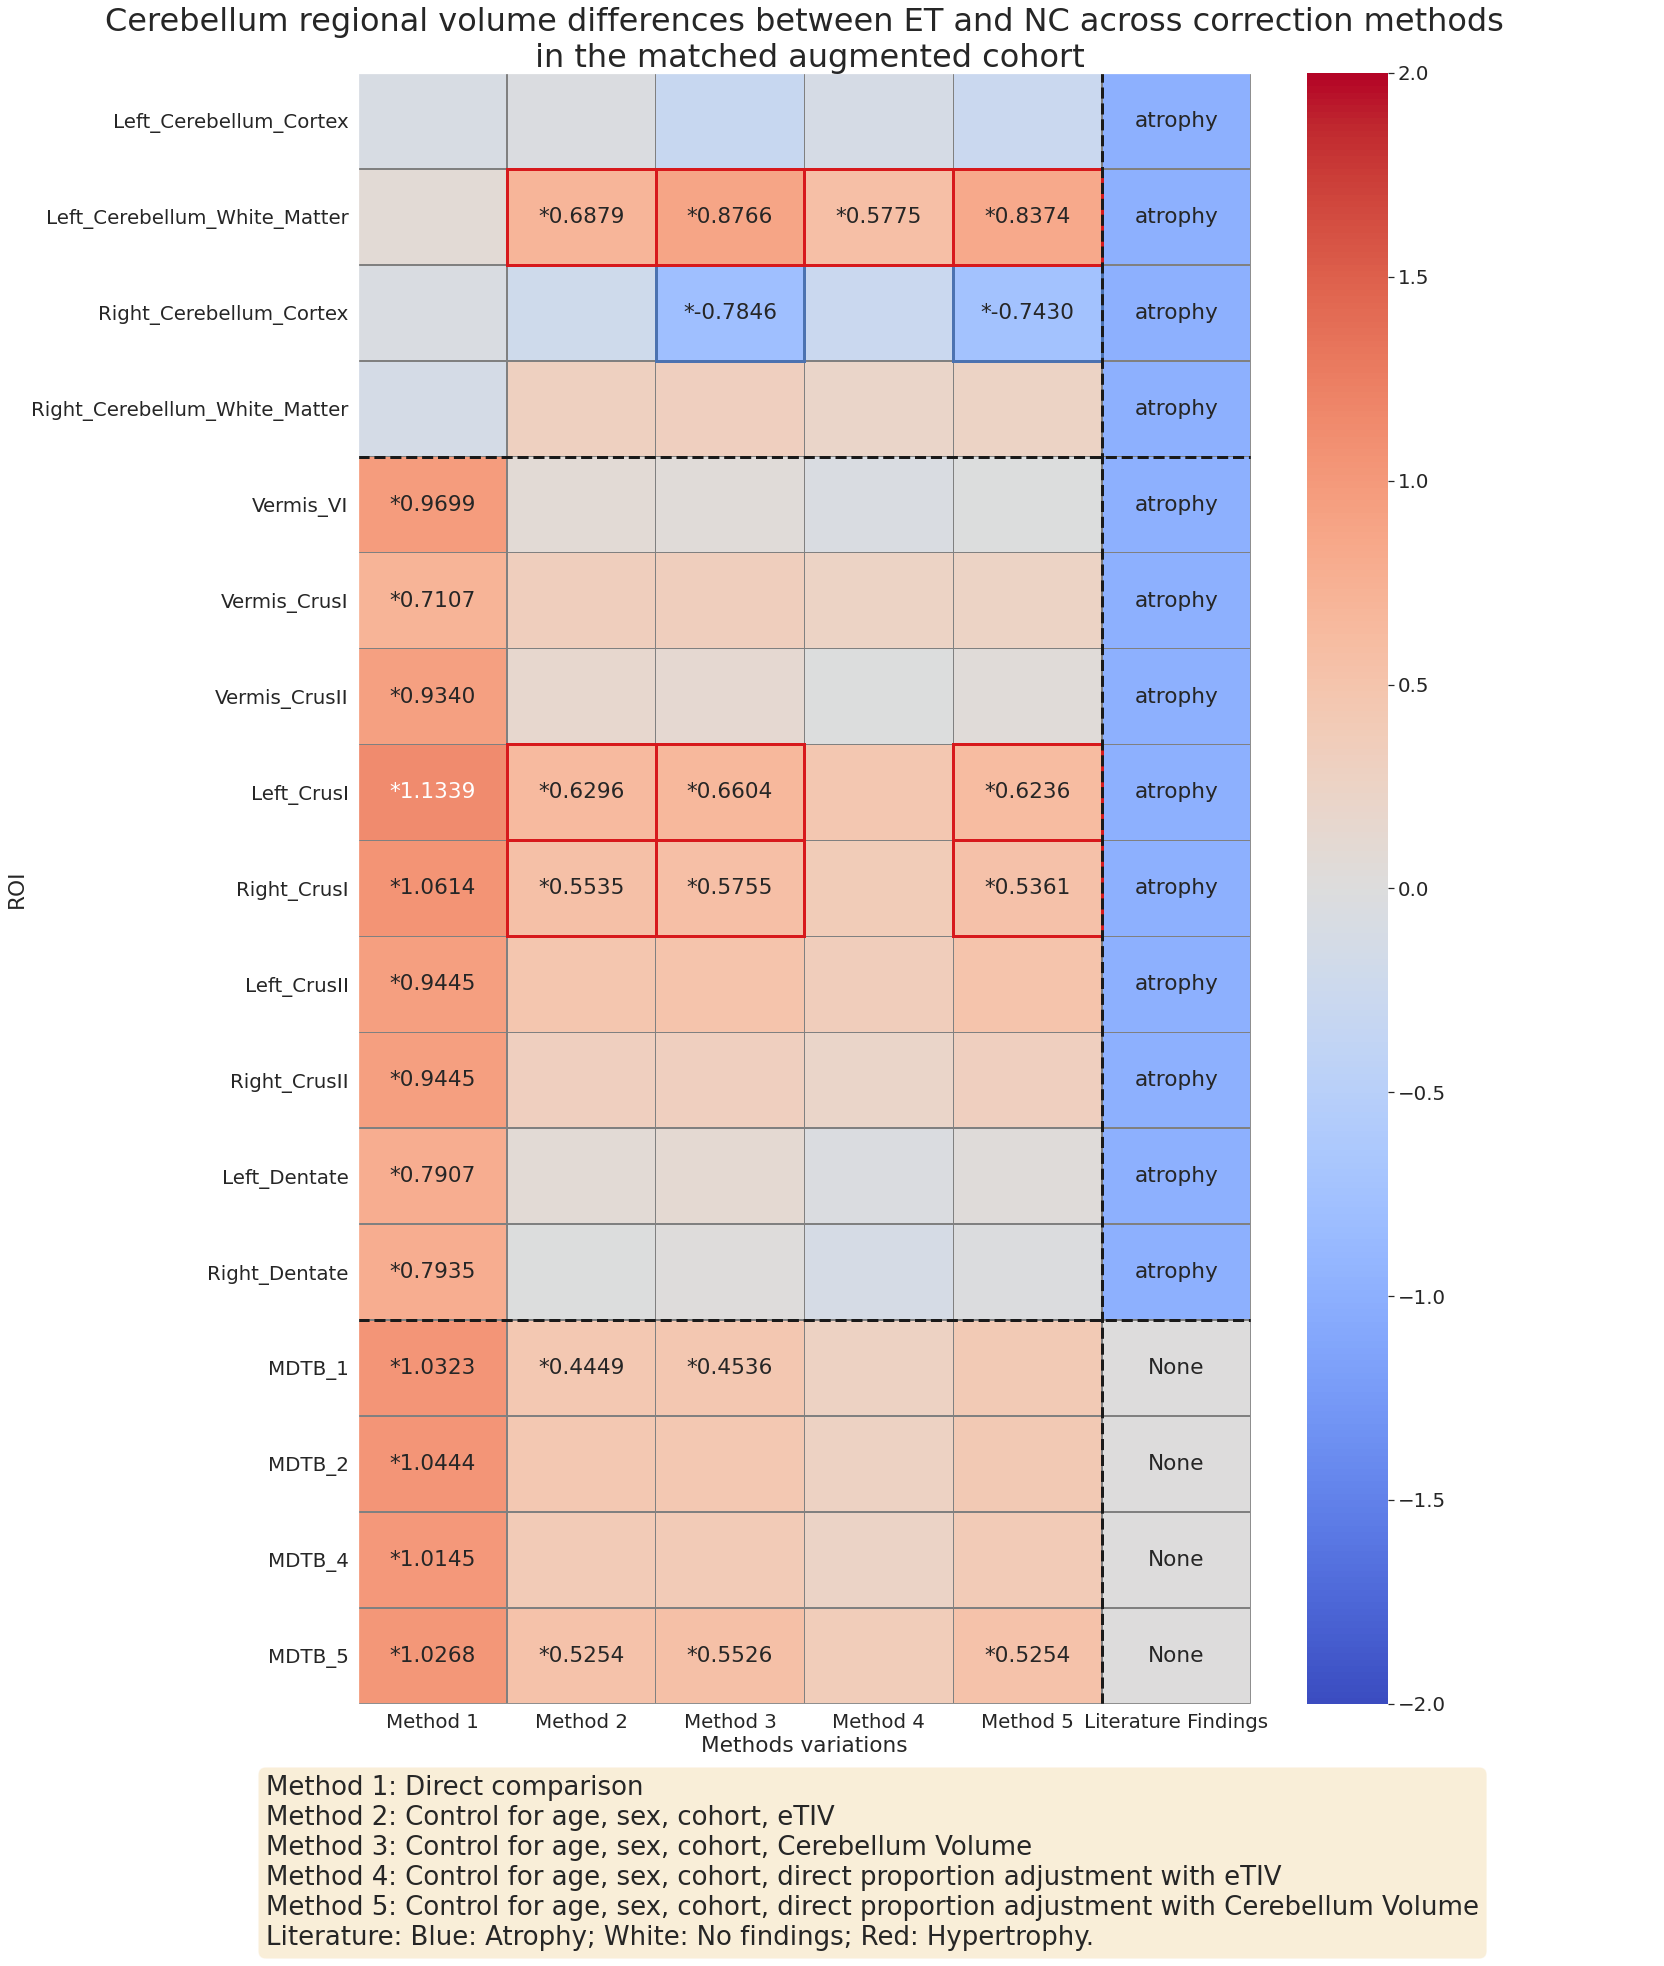

In [70]:
# This is the figure created for communication with PLoS Biol editor about our priliminary results.
# historical version, never run it!
figure_size=(20, 30);
legend_text_pos=[0.5, 0.42];
legend_font_size=26

C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.8)
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_DPA with A,S,Cere']

vis_df = matched_method_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]

# reorder rows
es_df_=es_df_.reindex(tar_list)
p_df_=p_df_.reindex(tar_list)
# create multiple comparison mask
def f(x):
    if float(x)==0:
        return ""
    else:
        return "*{:.4f}".format(x)
# Create 
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)

drop_cols=[2,5]; drop_rows=[4, 5];
es_df_.drop(es_df_.index[drop_rows], axis=0, inplace=True);
anno_df.drop(anno_df.index[drop_rows], axis=0, inplace=True);
es_df_.drop(es_df_.columns[drop_cols], axis=1, inplace=True);
anno_df.drop(anno_df.columns[drop_cols], axis=1, inplace=True);
xticklabels_str = [ 'Method '+str(x+1) for x in range(es_df_.shape[1])] +['Literature Findings']
es_df_.loc[:,'literature']  = 13*[-1]+4*[0];
anno_df.loc[:,'literature'] = 13*['atrophy']+4*['None'];

# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray')
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str,
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2)
ax2.set_xlabel("Methods variations")
ax2.set_title('Cerebellum regional volume differences between ET and NC across correction methods\n in the matched augmented cohort', fontsize=32)
for _, spine in ax2.spines.items(): spine.set_visible(True)

# adding more repliccability information (need QC done)
lit_roi_all=[(2,2), (4,2) ]
for x_ in lit_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))

conflict_roi_all=[(1,1), (2,1),(3,1),(4,1) ]+[(1,7),(1,8)]+[(2,7),(2,8)]+[(4,7),(4,8)]
for x_ in conflict_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='#d7191c', lw=3))
    
line_pos=[4,13]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3)
plt.axvline(5, ls='--',c='k', lw=3)

## adding text boxes
textstr = '\n'.join([
    r'Method 1: Direct comparison',
    r'Method 2: Control for age, sex, cohort, eTIV',
    r'Method 3: Control for age, sex, cohort, Cerebellum Volume',
    r'Method 4: Control for age, sex, cohort, direct proportion adjustment with eTIV',
    r'Method 5: Control for age, sex, cohort, direct proportion adjustment with Cerebellum Volume',
    r'Literature: Blue: Atrophy; White: No findings; Red: Hypertrophy.'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos[0], legend_text_pos[1], textstr, transform=ax.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props)
plt.show()
f2.savefig("matched-corhorts_qc_methods-Sensitivity_non-parametric_plosbio_comm.jpg")